In [2]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset


In [4]:
# Auxiliary functions
def sanity_check():
    pass

## Descriptive Analysis and Pre-processing of the Data

In [5]:
df = pd.read_csv('stock_data.csv')
df.head(10)

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
5,PGNX Over 3.04,1
6,AAP - user if so then the current downtrend wi...,-1
7,Monday's relative weakness. NYX WIN TIE TAP IC...,-1
8,GOOG - ower trend line channel test & volume s...,1
9,AAP will watch tomorrow for ONG entry.,1


### 1. Observe the number of sentiment to handle data imbalance
- analysis: data is slightly imbalanced with a 2:3 ratio
- action: use downsampling to balance the data (caveat: loss of information)

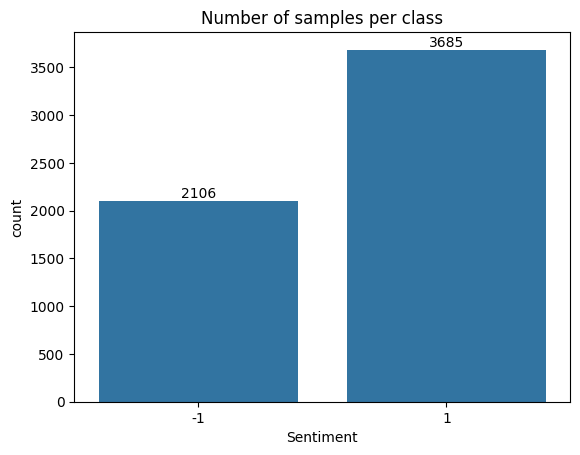

In [4]:
def check_class_imbalance(df):
    '''print out the number of samples per class'''
    
    ax = sns.countplot(x='Sentiment', data=df)
    ax.set_title('Number of samples per class')
    ax.bar_label(ax.containers[0])
    
check_class_imbalance(df)

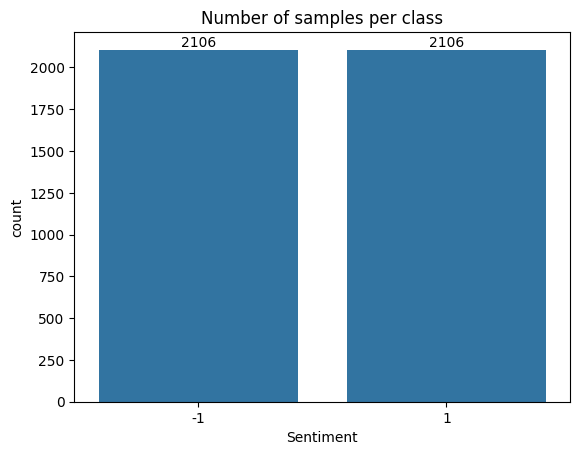

In [5]:
# execution of down sampling 
def down_sampling_to_equal_amount(df):
    '''downsampling to equal amount of samples for each class, index will be reset'''

    n_samples = df.Sentiment.value_counts().min()
    df_copy = df.groupby('Sentiment').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)
    
    return df_copy.sample(frac=1)

df = down_sampling_to_equal_amount(df)
check_class_imbalance(df)

### 2. Observe the length of input text
- length analysis: the length of each input is almost symmetrically distributed between 2 and 32; 
    - no significant outliers
    - no significant difference between the length of 1 and -1 sentiment labels
- action : None, padding will be done together with data preprocessing before training


In [6]:
def print_range_of_text_length(df):
    '''print out the range of text length'''
    
    df['text_length'] = df['Text'].apply(lambda x: len(x.split()))
    print(f"Range of text length: {df['text_length'].min()} - {df['text_length'].max()}")

print_range_of_text_length(df)

Range of text length: 2 - 32


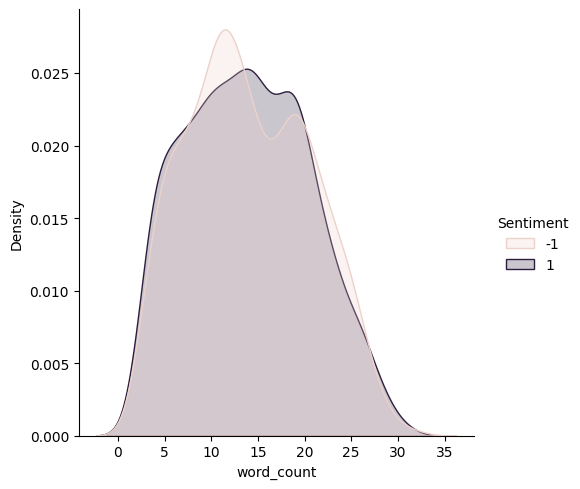

In [7]:
def plot_word_distribution(df):
    '''plot the distribution of the number of words in each sample'''
    
    df['word_count'] = df['Text'].apply(lambda x: len(x.split()))
    ax = sns.displot(data=df, x='word_count', hue='Sentiment', kind='kde', fill=True)
    ax.set_titles('Distribution of number of words in each sample')

plot_word_distribution(df)

### 3. Observe the number of unique charaters in the input text
- action: None, can be done by pre-trained model from hugging face

/Users/pangyen/anaconda3/envs/bert-venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


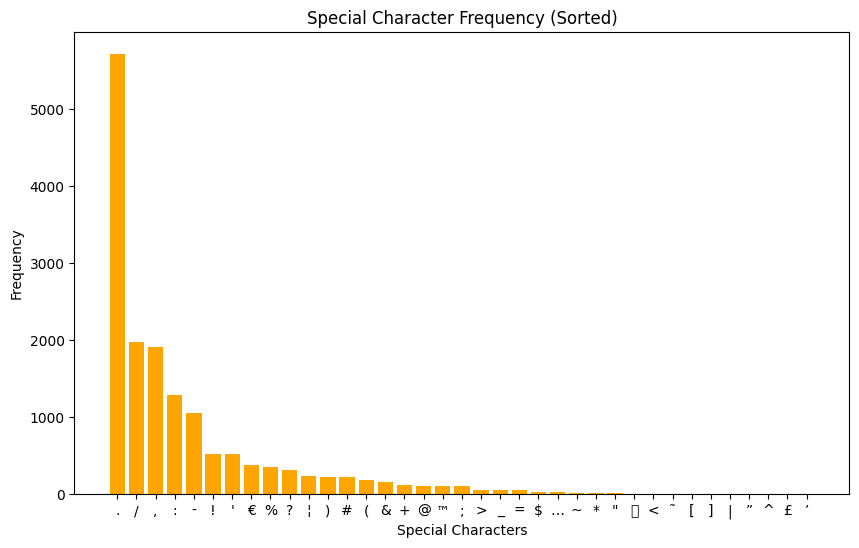

In [8]:
from collections import Counter

def plot_special_character_frequency(df):
    '''plot the frequency of special characters'''
    
    all_text = ''.join(df['Text'])
    special_char_counter = Counter(char for char in all_text if not char.isalnum() and not char.isspace())
    sorted_special_chars = sorted(special_char_counter, key=special_char_counter.get, reverse=True)
    sorted_counts = [special_char_counter[char] for char in sorted_special_chars]

    # Plot the occurrences of different special characters
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_special_chars, sorted_counts, color='orange')
    plt.title('Special Character Frequency (Sorted)')
    plt.xlabel('Special Characters')
    plt.ylabel('Frequency')
    plt.show()

plot_special_character_frequency(df)

## Import pre-trained model from hugging face

In [6]:
# Load the tokenizer and model
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data Preprocessing for BERT
1. Replace the -1 sentiment label with 0 to be consistent with the BERT model
2. Train test split
3. Tokenize the input text and wrap them into HuggingFace dataset

In [7]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# 1. replace -1 as 0
df['Sentiment'] = df['Sentiment'].replace(-1, 0) 

# 2. Split the data into training and testing
train_df, test_df = train_test_split(df, test_size=0.1, random_state=40)

# 3. Tokenize the dataset
train_tokenized = tokenizer(train_df["Text"].tolist(), truncation=True, padding=True)
test_tokenized = tokenizer(test_df["Text"].tolist(), truncation=True, padding=True)

# 4. Create datasets
train_dataset = Dataset.from_dict({"input_ids": train_tokenized["input_ids"], "attention_mask": train_tokenized["attention_mask"], "label": train_df["Sentiment"]})
test_dataset = Dataset.from_dict({"input_ids": test_tokenized["input_ids"], "attention_mask": test_tokenized["attention_mask"], "label": test_df["Sentiment"]})

Validation of the data preprocessing:

In [11]:
# Display a few samples from the training dataset
print("Training Dataset:")
for i in range(5):  # Display the sentiment labels for the first 5 samples
    sample = train_dataset[i]
    print(f"Sample {i + 1}: Text - {sample['input_ids']}, Sentiment - {sample['label']}")

# Display a few samples from the testing dataset
print("\nTesting Dataset:")
for i in range(5):  # Display the sentiment labels for the first 5 samples
    sample = test_dataset[i]
    print(f"Sample {i + 1}: Text - {sample['input_ids']}, Sentiment - {sample['label']}")


Training Dataset:
Sample 1: Text - [0, 846, 9482, 2227, 6, 364, 16434, 784, 12771, 359, 22254, 15, 13103, 6, 784, 7165, 5954, 981, 6, 21779, 2523, 29885, 154, 4, 1599, 75, 8861, 8383, 4, 211, 27140, 208, 7111, 250, 854, 13042, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Sentiment - 0
Sample 2: Text - [0, 6842, 487, 38, 216, 24, 18, 10, 5373, 802, 6, 53, 13331, 17717, 42, 1411, 2272, 30, 381, 7111, 116, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Sentiment - 1
Sample 3: Text - [0, 250, 591, 4614, 26305, 5457, 18071, 531, 1474, 5, 2904, 36, 1779, 5, 3149, 630, 75, 323, 5, 2904, 43, 1437, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Sentiment - 0
Sample 4: Text - [0, 8573, 111, 10883, 66, 5, 1445, 186, 4, 22768, 172, 291, 5273, 15, 1230, 4, 25096, 999, 4114, 4, 1437, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

## Fine-Tuning BERT

In [12]:
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, confusion_matrix
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Compute the confusion matrix
    conf_mat = confusion_matrix(labels, predictions)
    
    # Print or return the confusion matrix
    print("Confusion Matrix:")
    print(conf_mat)
    
    # Return a dictionary with additional metrics if needed
    return accuracy.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir="./sentiment_model",
    learning_rate=1e-5,
    num_train_epochs=6,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


## Training and Evaluation

In [13]:
trainer.train()

  0%|          | 0/2844 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Checkpoint destination directory ./sentiment_model/checkpoint-474 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Confusion Matrix:
[[163  40]
 [ 56 163]]
{'eval_loss': 0.5245025753974915, 'eval_accuracy': 0.7725118483412322, 'eval_runtime': 1.8381, 'eval_samples_per_second': 229.582, 'eval_steps_per_second': 28.834, 'epoch': 1.0}
{'loss': 0.5963, 'learning_rate': 8.241912798874826e-06, 'epoch': 1.05}


  0%|          | 0/53 [00:00<?, ?it/s]

Checkpoint destination directory ./sentiment_model/checkpoint-948 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Confusion Matrix:
[[168  35]
 [ 60 159]]
{'eval_loss': 0.4920031428337097, 'eval_accuracy': 0.7748815165876777, 'eval_runtime': 1.3414, 'eval_samples_per_second': 314.594, 'eval_steps_per_second': 39.511, 'epoch': 2.0}
{'loss': 0.4203, 'learning_rate': 6.483825597749649e-06, 'epoch': 2.11}


  0%|          | 0/53 [00:00<?, ?it/s]

Checkpoint destination directory ./sentiment_model/checkpoint-1422 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Confusion Matrix:
[[159  44]
 [ 44 175]]
{'eval_loss': 0.5923607349395752, 'eval_accuracy': 0.7914691943127962, 'eval_runtime': 1.3533, 'eval_samples_per_second': 311.83, 'eval_steps_per_second': 39.163, 'epoch': 3.0}
{'loss': 0.3411, 'learning_rate': 4.725738396624473e-06, 'epoch': 3.16}


  0%|          | 0/53 [00:00<?, ?it/s]

Checkpoint destination directory ./sentiment_model/checkpoint-1896 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Confusion Matrix:
[[166  37]
 [ 44 175]]
{'eval_loss': 0.840889036655426, 'eval_accuracy': 0.8080568720379147, 'eval_runtime': 1.3244, 'eval_samples_per_second': 318.646, 'eval_steps_per_second': 40.02, 'epoch': 4.0}
{'loss': 0.3039, 'learning_rate': 2.967651195499297e-06, 'epoch': 4.22}


  0%|          | 0/53 [00:00<?, ?it/s]

Checkpoint destination directory ./sentiment_model/checkpoint-2370 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Confusion Matrix:
[[162  41]
 [ 42 177]]
{'eval_loss': 0.9335609078407288, 'eval_accuracy': 0.8033175355450237, 'eval_runtime': 1.3399, 'eval_samples_per_second': 314.946, 'eval_steps_per_second': 39.555, 'epoch': 5.0}
{'loss': 0.2534, 'learning_rate': 1.2095639943741212e-06, 'epoch': 5.27}


  0%|          | 0/53 [00:00<?, ?it/s]

Checkpoint destination directory ./sentiment_model/checkpoint-2844 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Confusion Matrix:
[[162  41]
 [ 41 178]]
{'eval_loss': 0.9963884949684143, 'eval_accuracy': 0.8056872037914692, 'eval_runtime': 1.4319, 'eval_samples_per_second': 294.714, 'eval_steps_per_second': 37.014, 'epoch': 6.0}
{'train_runtime': 562.0629, 'train_samples_per_second': 40.458, 'train_steps_per_second': 5.06, 'train_loss': 0.3599097416873723, 'epoch': 6.0}


TrainOutput(global_step=2844, training_loss=0.3599097416873723, metrics={'train_runtime': 562.0629, 'train_samples_per_second': 40.458, 'train_steps_per_second': 5.06, 'train_loss': 0.3599097416873723, 'epoch': 6.0})

1. model: 
distilbert-base-uncased, batch_size=8, learning_rate=1e-5
{'train_runtime': 293.6624, 'train_samples_per_second': 77.436, 'train_steps_per_second': 9.685, 'train_loss': 0.32372328064780365, 'epoch': 6.0}

2. model: roberta-base, batch_size=8, learning_rate=1e-5
{'eval_loss': 0.9408127665519714,
 'eval_accuracy': 0.8199052132701422,
 'eval_runtime': 2.0012,
 'eval_samples_per_second': 210.876,
 'eval_steps_per_second': 26.484,
 'epoch': 6.0}

 3. model: bert-base-uncased, batch_size=8, learning_rate=1e-5
 {'eval_loss': 0.9435577988624573,
 'eval_accuracy': 0.8293838862559242,
 'eval_runtime': 1.2172,
 'eval_samples_per_second': 346.696,
 'eval_steps_per_second': 43.542,
 'epoch': 6.0}

 4. bert-base-cased, batch_size=8, learning_rate=1e-5
 {'eval_loss': 0.5547063946723938,
 'eval_accuracy': 0.7748815165876777,
 'eval_runtime': 1.4587,
 'eval_samples_per_second': 289.303,
 'eval_steps_per_second': 36.334,
 'epoch': 3.0}

In [14]:
results = trainer.evaluate()

  0%|          | 0/53 [00:00<?, ?it/s]

Confusion Matrix:
[[162  41]
 [ 41 178]]


In [15]:
results

{'eval_loss': 0.9963884949684143,
 'eval_accuracy': 0.8056872037914692,
 'eval_runtime': 1.3503,
 'eval_samples_per_second': 312.513,
 'eval_steps_per_second': 39.249,
 'epoch': 6.0}

In [16]:
print("Final accuracy:", results["eval_accuracy"])

Final accuracy: 0.8056872037914692


In [17]:
trainer.save_model("./saved_model")

## Load Model and re-evaluate the data set

In [9]:
model_LOAD = RobertaForSequenceClassification.from_pretrained("./saved_model")
tokenizer_LOAD = RobertaTokenizer.from_pretrained('roberta-base')

In [10]:
text_check = "The market is bullish"
pipe_load = pipeline(task='text-classification',model=model_LOAD, tokenizer=tokenizer_LOAD)
pipe_load(text_check)

[{'label': 'LABEL_1', 'score': 0.9993450045585632}]

### prepare train and test data

In [11]:
train_text = train_df.iloc[:,0].tolist()
train_label = train_df.iloc[:,1].tolist()

test_text = test_df.iloc[:,0].tolist()
test_label = test_df.iloc[:,1].tolist()

In [12]:
def predict_text(text_set):
    '''predict the sentiment of the given text'''
    pred_label = []
    for text in text_set:
        model_output = pipe_load(text)

        if model_output[0]['label'] == "LABEL_1":
            pred_label.append(1)
        else:
            pred_label.append(0)
    
    return pred_label      
                     
pred_train_label = predict_text(train_text)
pred_test_label = predict_text(test_text)

KeyboardInterrupt: 

### draw confusion matrix

In [13]:
import seaborn as sns  
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix  

train_conf_mat = confusion_matrix(train_label, pred_train_label)  
test_conf_mat = confusion_matrix(test_label, pred_test_label)  
    
def plot_confusion_matrix_pair(train_label, pred_train_label, test_label, pred_test_label):
    '''plot the confusion matrix for both training and testing data'''
    
    conf_mat_train = confusion_matrix(train_label, pred_train_label)
    conf_mat_test = confusion_matrix(test_label, pred_test_label)
    
    # Plot using seaborn
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(conf_mat_train, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title("Train Confusion Matrix")
    ax[0].set_ylabel("Actual Label")
    ax[0].set_xlabel("Predicted Label")
    
    sns.heatmap(conf_mat_test, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title("Test Confusion Matrix")
    ax[1].set_ylabel("Actual Label")
    ax[1].set_xlabel("Predicted Label")
    
        
plot_confusion_matrix_pair(train_label, pred_train_label, test_label, pred_test_label)
  

NameError: name 'pred_train_label' is not defined

## Evaluate different dataset

In [73]:
sentiment_df = pd.read_csv('sentiment_data.csv', encoding='cp1252')

In [74]:
new_column_nams = ['Sentiment', 'Text']
sentiment_df.columns = new_column_nams
sentiment_df

,Sentiment,Text
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower...
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4843,negative,Net sales of the Paper segment decreased to EU...


### preprocess the data for evaluation

In [75]:
# filter out the neutral sentiment
sentiment_df['Sentiment'] = sentiment_df['Sentiment'].replace('negative', 0)
sentiment_df['Sentiment'] = sentiment_df['Sentiment'].replace('positive', 1)
sentiment_df['Sentiment'] = sentiment_df['Sentiment'].replace('neutral', 2)
sentiment_df_no_neutral = sentiment_df[sentiment_df['Sentiment'] != 2]
sentiment_df_no_neutral

,Sentiment,Text
1,0,The international electronic industry company ...
2,1,With the new production plant the company woul...
3,1,According to the company 's updated strategy f...
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
5,1,"For the last quarter of 2010 , Componenta 's n..."
...,...,...
4839,0,HELSINKI Thomson Financial - Shares in Cargote...
4840,0,LONDON MarketWatch -- Share prices ended lower...
4842,0,Operating profit fell to EUR 35.4 mn from EUR ...
4843,0,Net sales of the Paper segment decreased to EU...


In [79]:
def predict_single_text_with_score(text, pipe):
    '''Function to predict the sentiment of a single text and return score'''
    model_output = pipe(text)
    label = 1 if model_output[0]['label'] == "LABEL_1" else 0
    return label, model_output[0]['score']

def apply_sentiment_analysis_with_scores(df, pipe):
    '''Apply sentiment analysis to the given dataframe using df.apply and include scores'''
    # Extracting both label and score
    results = df['Text'].apply(lambda x: predict_single_text_with_score(x, pipe))
    df['Predicted Label'], df['Score'] = zip(*results)
    return df

sentiment_df_no_neutral = pd.read_csv('./processed_data/sentiment_df_no_neutral.csv', encoding='cp1252')
# sentiment_df_no_neutral = apply_sentiment_analysis_with_scores(sentiment_df_no_neutral, pipe_load)
sentiment_df_no_neutral

,Sentiment,Text,Predicted Label,Score
0,0.0,The international electronic industry company ...,0,0.998167
1,1.0,With the new production plant the company woul...,1,0.999074
2,1.0,According to the company 's updated strategy f...,1,0.997099
3,1.0,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1,0.999108
4,1.0,"For the last quarter of 2010 , Componenta 's n...",0,0.997696
...,...,...,...,...
1962,0.0,HELSINKI Thomson Financial - Shares in Cargote...,0,0.998707
1963,0.0,LONDON MarketWatch -- Share prices ended lower...,0,0.998862
1964,0.0,Operating profit fell to EUR 35.4 mn from EUR ...,0,0.998302
1965,0.0,Net sales of the Paper segment decreased to EU...,0,0.997944


In [63]:
# sentiment_df_no_neutral.to_csv('./processed_data/sentiment_df_no_neutral.csv', index=False)

### plot out the density of the output score

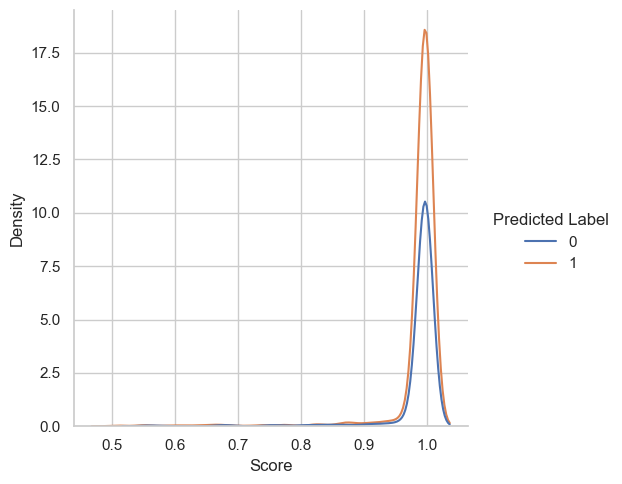

In [80]:
def plot_label_frequencies_sns(df):
    '''Plot the frequency of scores for each label using seaborn'''
    # Plotting the distribution of scores for each label
    # `kind='kde'` for density plots, `kind='hist'` for histograms
    g = sns.displot(data=df, x='Score', hue='Predicted Label', kind='kde')

    g.set_titles("Frequency of Scores by Label")
    g.set_axis_labels("Score", "Density")
    plt.show()
    
plot_label_frequencies_sns(sentiment_df_no_neutral)

### draw confusion matrix, compare the accuracy, precision, recall, and f1 score

In [81]:
sentiment_test_label = sentiment_df_no_neutral.iloc[:,0].tolist()
sentiment_pred_label = sentiment_df_no_neutral.iloc[:,2].tolist()

Sentiment Test Set:	 Accuracy: 0.94,	 F1: 0.93, Recall: 0.91,	 Precision: 0.99


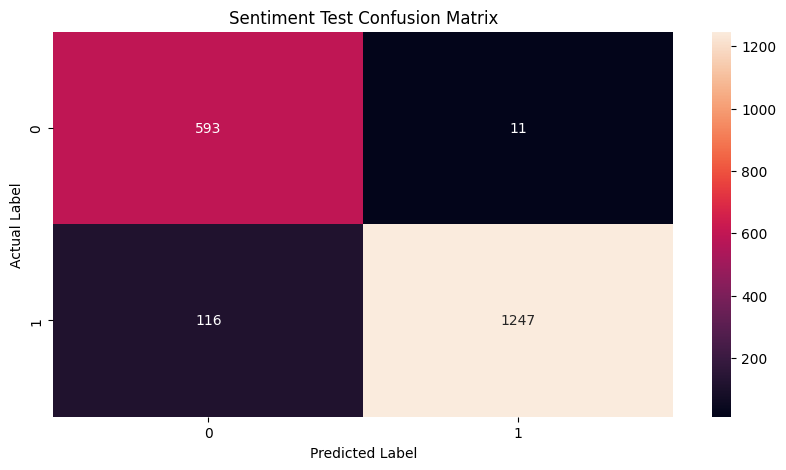

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def print_metrics(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)

    print(f"{dataset_name} Set:\t Accuracy: {accuracy:.2f},\t F1: {f1:.2f}, Recall: {recall:.2f},\t Precision: {precision:.2f}")



def plot_confusion_matrix(y_true, y_pred, title):
    '''plot the confusion matrix'''
    
    conf_mat = confusion_matrix(y_true, y_pred)
    
    # Plot using seaborn
    fig, ax = plt.subplots(figsize=(10, 5))  
    sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax)
    
    # Use the title parameter here
    ax.set_title(title)  
    ax.set_ylabel("Actual Label")  
    ax.set_xlabel("Predicted Label") 

print_metrics(sentiment_test_label, sentiment_pred_label, "Sentiment Test")
plot_confusion_matrix(sentiment_test_label, sentiment_pred_label, "Sentiment Test Confusion Matrix")

## Include neutral sentiment

In [82]:
sentiment_df

,Sentiment,Text
0,2,Technopolis plans to develop in stages an area...
1,0,The international electronic industry company ...
2,1,With the new production plant the company woul...
3,1,According to the company 's updated strategy f...
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4840,0,LONDON MarketWatch -- Share prices ended lower...
4841,2,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,0,Operating profit fell to EUR 35.4 mn from EUR ...
4843,0,Net sales of the Paper segment decreased to EU...


### Preprocess the data

In [83]:
def predict_single_text_with_score_neutral(text, pipe, threshold=0.8):
    '''Function to predict the sentiment of a single text and return score'''
    model_output = pipe(text)
    if model_output[0]['score'] < threshold:
        label = 2
    else:
        label = 1 if model_output[0]['label'] == "LABEL_1" else 0
    
    return label, model_output[0]['score']

def apply_sentiment_analysis_with_scores_neutral(df, pipe):
    '''Apply sentiment analysis to the given dataframe using df.apply and include scores'''
    # Extracting both label and score
    results = df['Text'].apply(lambda x: predict_single_text_with_score_neutral(x, pipe))
    df['Predicted Label'], df['Score'] = zip(*results)
    return df

aug_sentiment_df = pd.read_csv('./processed_data/aug_sentiment_df.csv', encoding='cp1252')
# aug_sentiment_df = apply_sentiment_analysis_with_scores_neutral(sentiment_df, pipe_load)
aug_sentiment_df

,Sentiment,Text,Predicted Label,Score
0,2,Technopolis plans to develop in stages an area...,1,0.999071
1,0,The international electronic industry company ...,0,0.998167
2,1,With the new production plant the company woul...,1,0.999074
3,1,According to the company 's updated strategy f...,1,0.997099
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1,0.999108
...,...,...,...,...
4840,0,LONDON MarketWatch -- Share prices ended lower...,0,0.998862
4841,2,Rinkuskiai 's beer sales fell by 6.5 per cent ...,0,0.997846
4842,0,Operating profit fell to EUR 35.4 mn from EUR ...,0,0.998302
4843,0,Net sales of the Paper segment decreased to EU...,0,0.997944


In [84]:
# aug_sentiment_df.to_csv('./processed_data/aug_sentiment_df.csv', index=False)

### Plot density, confusion matrix, and compare the accuracy, precision, recall, and f1 score

Augmented Sentiment Set:	 Accuracy: 0.40,	 F1: 0.40, Recall: 0.64,	 Precision: 0.53


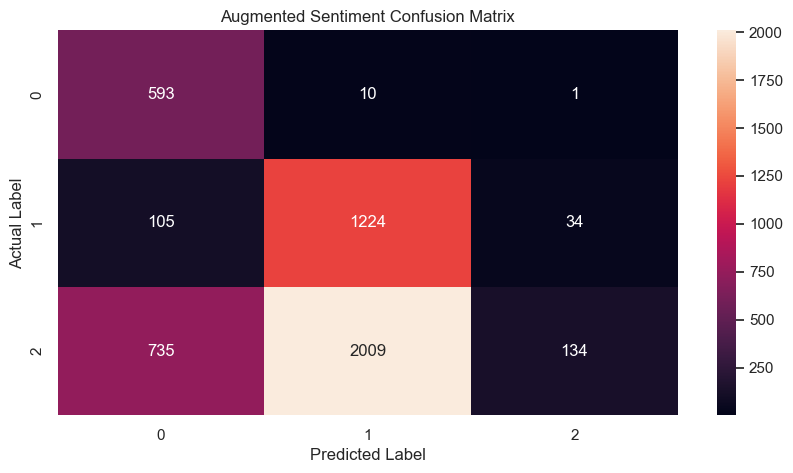

In [90]:
def print_metrics_multiclass(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    
    print(f"{dataset_name} Set:\t Accuracy: {accuracy:.2f},\t F1: {f1:.2f}, Recall: {recall:.2f},\t Precision: {precision:.2f}")

print_metrics_multiclass(aug_sentiment_df['Sentiment'], aug_sentiment_df['Predicted Label'], "Augmented Sentiment")
# plot_label_frequencies_sns(aug_sentiment_df)
plot_confusion_matrix(aug_sentiment_df['Sentiment'], aug_sentiment_df['Predicted Label'], "Augmented Sentiment Confusion Matrix")
